In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import functional as TF

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.nn.functional import interpolate

from tqdm import tqdm

from sklearn.metrics import jaccard_score

In [2]:
class RandomCropTransform:
    def __init__(self, output_size):
        """
        Initializes the random cropping transformation with a specified output size.

        Args:
            output_size (int): Side length of the output square for cropping.
        """
        self.output_size = output_size

    def __call__(self, image, mask):
        assert image.size[0] >= self.output_size and image.size[1] >= self.output_size
        
        white_threshold = 0.1  # Threshold for the maximum allowed white pixels in the crop
        max_attempts = 100  # Limit the number of attempts to find a suitable crop

        for _ in range(max_attempts):
            i = random.randint(0, image.size[0] - self.output_size)
            j = random.randint(0, image.size[1] - self.output_size)

            cropped_image = TF.crop(image, i, j, self.output_size, self.output_size)
            cropped_mask = TF.crop(mask, i, j, self.output_size, self.output_size)

            image_array = np.array(cropped_image)
            num_white_pixels = np.sum(np.all(image_array == [255, 255, 255], axis=-1))
            total_pixels = self.output_size * self.output_size
            if num_white_pixels / total_pixels < white_threshold:
                break
                
        # Apply additional random transformations
        if random.random() > 0.5:
            cropped_image, cropped_mask = TF.hflip(cropped_image), TF.hflip(cropped_mask)
        if random.random() > 0.5:
            cropped_image, cropped_mask = TF.vflip(cropped_image), TF.vflip(cropped_mask)
        if random.random() > 0.5:
            angle = 90
            cropped_image, cropped_mask = TF.rotate(cropped_image, angle), TF.rotate(cropped_mask, angle)

        return cropped_image, cropped_mask
    
class SatelliteBuildingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_image=None, transform_mask=None):
        """
        Initializes the SatelliteBuildingDataset class with specific directories for images and masks,
        and with optional transformations that can be applied to both images and masks.

        Args:
            image_dir (string): Directory containing all images.
            mask_dir (string): Directory containing all masks.
            transform_image (callable, optional): Optional transformation function to apply to images.
            transform_mask (callable, optional): Optional transformation function to apply to masks.
        """
        # Assign to instance variables the values of the parameters
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        # List all files in the image directory. It is assumed that each image has its corresponding mask.
        self.images = os.listdir(image_dir)

    def __len__(self):
        # Returns the total number of images in the dataset
        return len(self.images)

    def __getitem__(self, idx):
        # Build the full paths for the image and mask using the provided index
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])
        
        # Open the image and convert it to RGB color
        image = Image.open(img_name).convert("RGB")
        # Open the mask and convert it to grayscale so that it has a single channel
        mask = Image.open(mask_name).convert("L")  

        # Apply the specified transformations to the image and mask, if provided
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        # Return the processed image and mask
        return image, mask


class SatelliteDataset_onehot(Dataset):
    def __init__(self, image_dir, mask_dir, output_size, transform=None, resize=True):
        """
        Initializes the satellite dataset with capabilities to transform images and masks.

        Args:
            image_dir (str): Directory with images.
            mask_dir (str): Directory with masks.
            output_size (int): Side length of the output square for cropping.
            transform (callable, optional): Transformations to apply to the masks.
            resize (bool): Whether to apply cropping and resizing.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = [img for img in os.listdir(image_dir) if img.endswith('.png')]
        self.transform = transform
        self.crop_transform = RandomCropTransform(output_size)
        self.resize = resize
        self.output_size = output_size
        self.resize_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.resize:
            image, mask = self.crop_transform(image, mask)
            image = self.resize_transform(image)
            mask = self.transform(mask)
        else:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [3]:
class ToOneHot:
    def __init__(self, n_classes=2):
        """
        Initializes a transformer that converts masks to one-hot representation.

        Args:
            n_classes (int): Number of distinct classes in the mask, including the background.
        """
        self.n_classes = n_classes

    def __call__(self, mask):
        """
        Applies the transformation to a mask.

        Args:
            mask (PIL Image or ndarray): Input mask.

        Returns:
            Tensor: Mask in one-hot format as a PyTorch tensor.
        """
        # Convert the mask to a numpy array and adjust the values to 0 or 1
        mask_array = np.array(mask)
        mask_array = np.where(mask_array == 255, 1, 0)  # Convert 255 to 1, keeping 0 as is
        # Convert the adjusted mask to a tensor
        mask_tensor = torch.as_tensor(mask_array, dtype=torch.int64)
        # Apply one_hot
        one_hot = torch.nn.functional.one_hot(mask_tensor, num_classes=self.n_classes).permute(2, 0, 1).float()
        return one_hot

def create_dataloaders_onehot(base_path, resize, batch_size=4):
    """
    Creates dataloaders for training and validation with specific transformations, including one-hot for the masks.

    Args:
        base_path (str): Base path where image and mask directories are located.
        resize (int): Size to which images and masks will be resized.
        batch_size (int): Number of elements in each data batch.

    Returns:
        tuple: Two DataLoaders, one for training and another for validation.
    """
    # Transformations for images
    transform_image = transforms.Compose([
        transforms.Resize(1344),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    transform_mask_train = transforms.Compose([
        transforms.Resize(resize),
        ToOneHot(),
        # transforms.ToTensor()
    ])

    transform_mask_val = transforms.Compose([
        transforms.Resize(1344),
        ToOneHot(),
        # transforms.ToTensor()
    ])
    
    # Data directories
    train_dir = os.path.join(base_path, 'train')
    train_mask_dir = os.path.join(base_path, 'train_labels')
    val_dir = os.path.join(base_path, 'val')
    val_mask_dir = os.path.join(base_path, 'val_labels')
    
    # Create datasets and dataloaders
    train_dataset = SatelliteDataset_onehot(train_dir, train_mask_dir, output_size=resize, transform=transform_mask_train, resize=True)
    val_dataset = SatelliteBuildingDataset(val_dir, val_mask_dir, transform_image, transform_mask_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


base_path = os.getcwd()
base_path = os.path.join(base_path, 'MBDS/png')


output_size = 128
train_loader, val_loader = create_dataloaders_onehot(base_path, output_size)

Image shape: torch.Size([3, 128, 128]) Mask shape: torch.Size([2, 128, 128])
Image shape: torch.Size([3, 128, 128]) Mask shape: torch.Size([2, 128, 128])
Image shape: torch.Size([3, 128, 128]) Mask shape: torch.Size([2, 128, 128])
Image shape: torch.Size([3, 128, 128]) Mask shape: torch.Size([2, 128, 128])


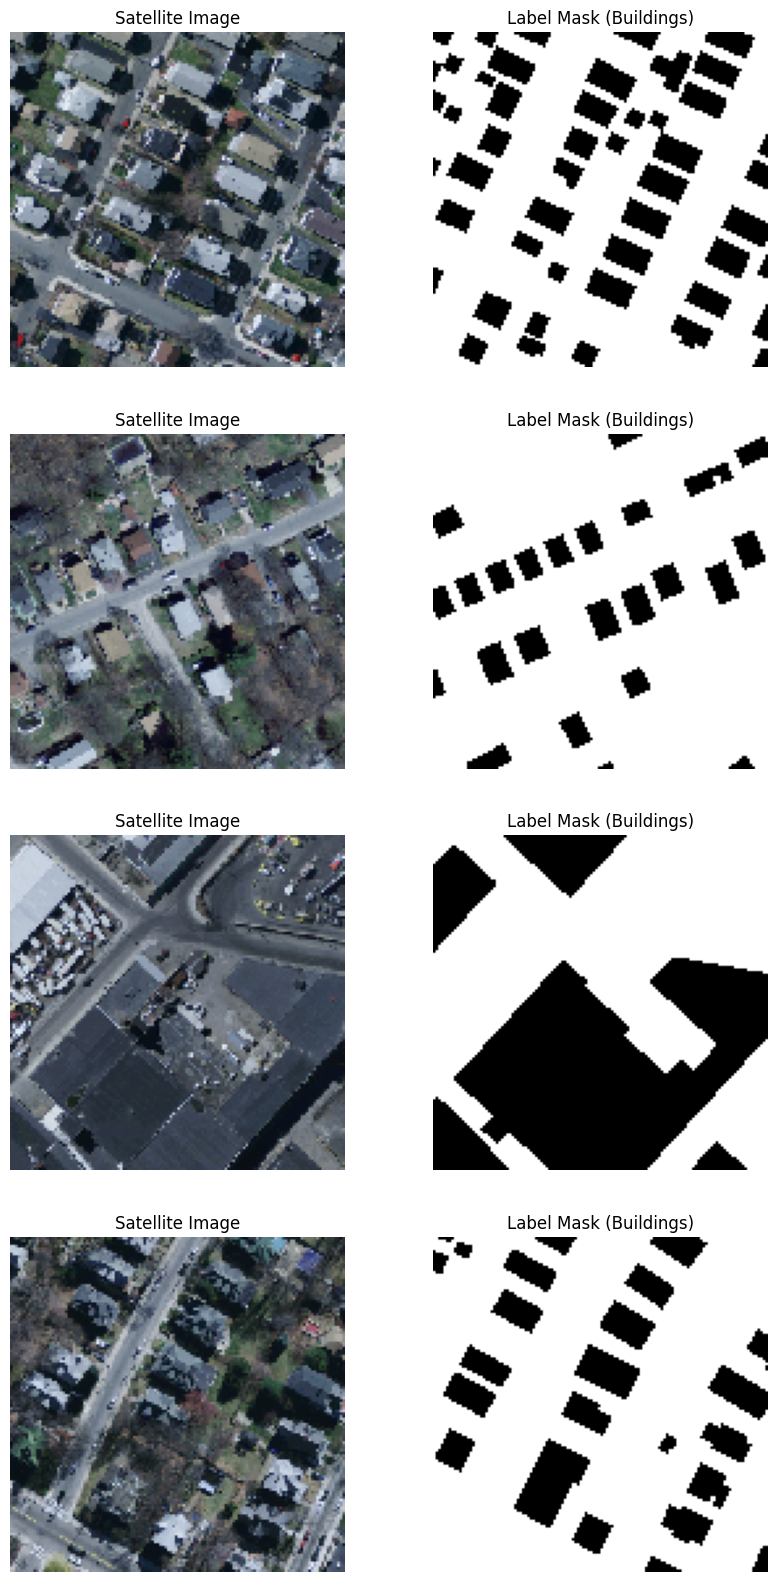

In [4]:
def show_images(images, masks, num_images=4):
    """
    Displays a set of images and masks.

    Args:
        images (Tensor): Tensor of images with dimensions [batch_size, channels, height, width].
        masks (Tensor): Tensor of masks with dimensions [batch_size, channels, height, width], 
                        where each channel represents a different class.
        num_images (int): Number of images and masks to show.
    """
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    for i in range(num_images):
        # Reorder the image channels for visualization
        img = images[i].permute(1, 2, 0)
        img = img.numpy()
        # Normalize the image to enhance visualization
        img = (img - img.min()) / (img.max() - img.min())
        
        # Select the channel corresponding to the class of interest, e.g., buildings
        mask = masks[i][0]  # Assuming the second channel represents buildings
        mask = mask.numpy()

        # Print dimensions to verify correctness
        print("Image shape:", images[i].shape, "Mask shape:", masks[i].shape)
        
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 0].set_title('Satellite Image')
        axs[i, 1].set_title('Label Mask (Buildings)')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
    plt.show()

# Assuming `train_loader` is already defined and loaded properly
images, masks = next(iter(train_loader))  # Load a batch of images and masks from the DataLoader
show_images(images, masks)  # Call the function to display the images

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Bloque de doble convolución que aplica dos capas de convolución con una capa de 
        normalización por lotes y activación ReLU entre ellas.

        Args:
            in_channels (int): Número de canales de entrada.
            out_channels (int): Número de canales de salida.
        """
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Bloque de descenso en U-Net que incluye un DoubleConv seguido por un max pooling 
        para reducir la dimensión espacial.

        Args:
            in_channels (int): Número de canales de entrada.
            out_channels (int): Número de canales de salida después de DoubleConv.
        """
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        """
        Bloque de ascenso en U-Net que realiza un upsampling y combina características
        de capas anteriores a través de la operación de concatenación.

        Args:
            in_channels (int): Número total de canales de entrada (suma de canales de salida del bloque anterior y del skip connection).
            out_channels (int): Número de canales de salida.
            up_sample_mode (str): Modo de upsampling, 'conv_transpose' para ConvTranspose2d o 'bilinear' para interpolación bilineal.
        """
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        """
        Initializes the U-Net with a descending and ascending path, including a final block.

        Args:
            out_classes (int): Number of output classes for segmentation.
            up_sample_mode (str): Method for upsampling; either 'conv_transpose' or 'bilinear'.
        """
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Initialize the descending blocks
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Initialize the ascending blocks
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final convolutional layer
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Defines the data flow through the network, using the defined blocks.

        Args:
            x (Tensor): Input image.

        Returns:
            Tensor: Network outputs with class probabilities.
        """
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        x = self.softmax(x)  # Apply softmax to the last layer
        return x

In [6]:
def split_image_into_segments(image_tensor, output_size):
    """
    Splits a large image into smaller segments.

    Args:
        image_tensor (Tensor): Input image.
        output_size (int): Size of each square segment.

    Returns:
        list: List of image segments.
        list: List of coordinates corresponding to each segment.
    """
    _, h, w = image_tensor.shape
    segments = []
    coords = []
    for i in range(0, h, output_size):
        for j in range(0, w, output_size):
            right = min(j + output_size, w)
            lower = min(i + output_size, h)
            segment = image_tensor[:, i:lower, j:right]
            segments.append(segment)
            coords.append((j, i))
    return segments, coords

def predict_and_recombine_segments(segments, coords, model, output_size, image_shape, device):
    """
    Predicts and recombines image segments to form the complete mask.

    Args:
        segments (list): Image segments.
        coords (list): Coordinates of each segment in the original image.
        model (UNet): U-Net model.
        output_size (int): Size of each segment.
        image_shape (tuple): Original dimensions of the image.
        device (torch.device): Device on which the model is running.

    Returns:
        Tensor: Complete reconstructed mask.
    """
    full_mask = torch.zeros((2, image_shape[1], image_shape[2]), device=device)
    for segment, (x, y) in zip(segments, coords):
        segment = segment.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(segment)
        full_mask[:, y:y+output_size, x:x+output_size] = output.squeeze(0)
    return full_mask

def calculate_iou(outputs, masks):
    """
    Calculates the Intersection over Union (IoU) by interpolating the outputs if necessary to match the size of the masks.

    Args:
        outputs (Tensor): Model output masks.
        masks (Tensor): True masks for comparison.

    Returns:
        float: Mean IoU score.
    """
    if outputs.size()[2:] != masks.size()[2:]:
        outputs = F.interpolate(outputs, size=masks.size()[2:], mode='nearest')
    outputs = torch.sigmoid(outputs) > 0.5
    outputs = outputs.float()
    outputs = outputs.cpu().numpy().astype(np.uint8)
    masks = masks.cpu().numpy().astype(np.uint8)
    ious = [jaccard_score(m.flatten(), o.flatten(), zero_division=1) for m, o in zip(masks, outputs)]
    return np.mean(ious)

def validate_model(val_loader, model, output_size, device, criterion):
    """
    Evaluates the model on a validation dataset.

    Args:
        val_loader (DataLoader): DataLoader that provides batches of images and masks.
        model (nn.Module): Neural network model to evaluate.
        output_size (int): Size of the segments into which each image is divided.
        device (torch.device): Device where computations are performed (CPU or GPU).
        criterion (loss function): Loss function used to evaluate model accuracy.

    Returns:
        tuple: Average validation losses and average IoU scores.
    """
    model.eval()  # Sets the model to evaluation mode (important for deactivating dropout, batchnorm, etc.)
    val_losses = []  # List to store losses for each batch
    iou_scores = []  # List to store IoU scores for each batch

    for images, masks in val_loader:
        images = images.to(device)  # Send images to the appropriate device
        masks = masks.to(device)  # Send masks to the appropriate device

        # Tensor to store predictions for all images in the batch
        predictions = torch.zeros(masks.size(0), 2, masks.size(2), masks.size(3), device=device)

        # Process each image in the batch individually
        for i, image in enumerate(images):
            # Split the image into segments and obtain the coordinates of each segment
            segments, coords = split_image_into_segments(image.cpu(), output_size)
            # Predict and reconstruct the complete mask from the segments
            full_mask = predict_and_recombine_segments(segments, coords, model, output_size, image.shape, device)
            predictions[i] = full_mask.to(device)  # Save the reconstructed mask in the predictions tensor
        
        # Calculate loss for the batch using the specified loss function
        loss = criterion(predictions, masks.argmax(dim=1))  # Use argmax if masks are in one-hot format
        val_losses.append(loss.item())  # Add the batch's loss to the list of losses

        # Calculate IoU for the batch using the defined function
        iou = calculate_iou(predictions.argmax(dim=1), masks.argmax(dim=1))  # Use argmax to compare predicted classes
        iou_scores.append(iou)  # Add the IoU of the batch to the list of IoUs
        
    # Calculate and return the average of the losses and IoUs of all processed batches
    return np.mean(val_losses), np.mean(iou_scores)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

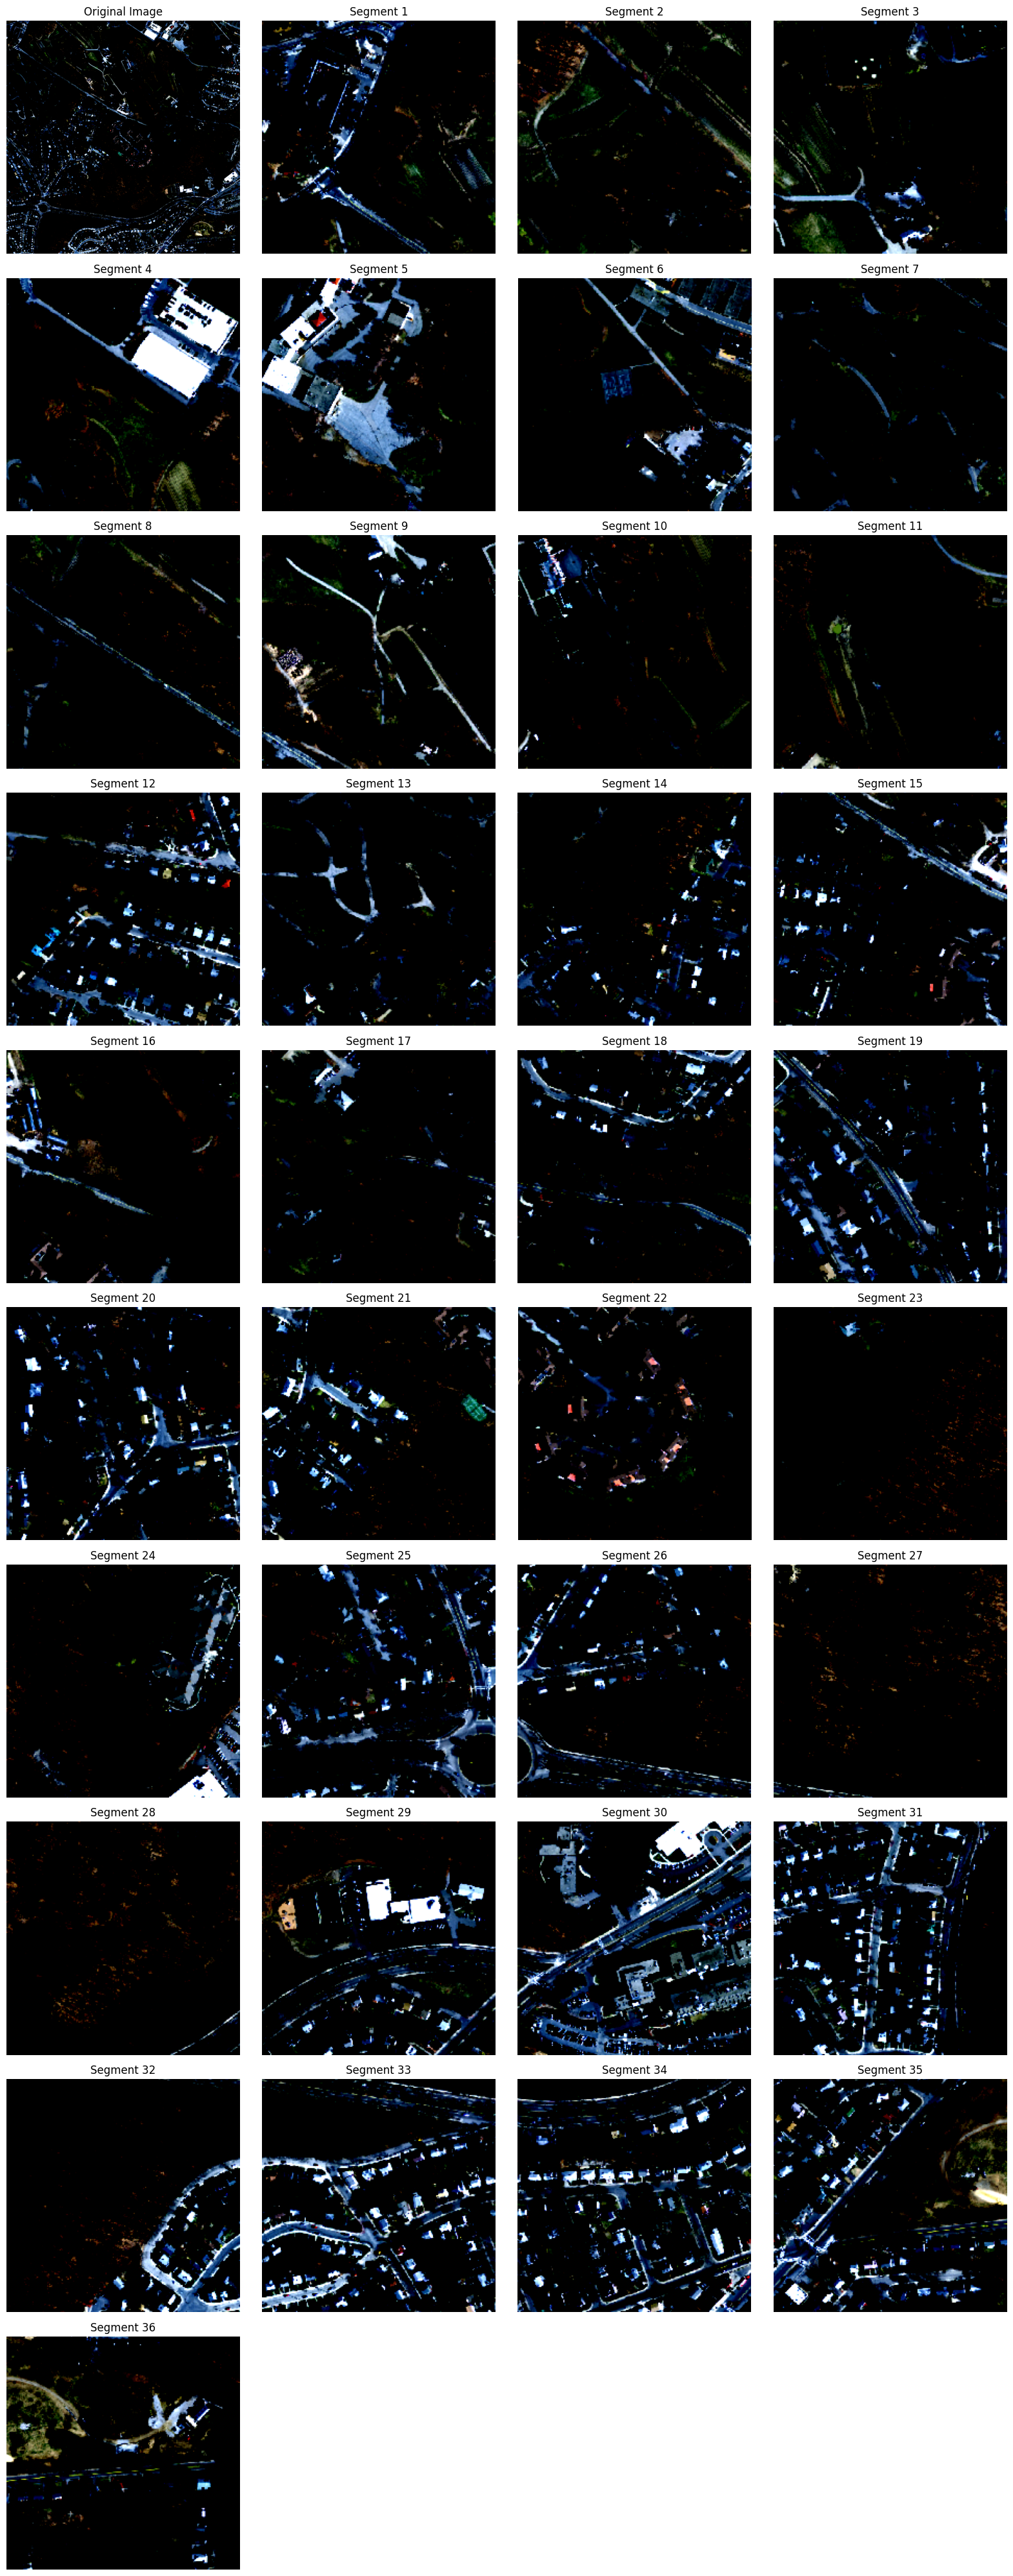

In [7]:
def visualize_image_and_segments(data_loader, output_size):
    """
    Visualizes the first image from a DataLoader and its resulting segments of a specified size.

    Args:
        data_loader (DataLoader): DataLoader that provides images and masks.
        output_size (int): Size of the square segments into which the image will be divided.
    """
    # Get a batch of images and masks
    images, masks = next(iter(data_loader))
    image = images[0]  # Take the first image from the batch
    mask = masks[0]    # Take the first mask from the batch

    # Split the image into segments using the defined function
    segments, coords = split_image_into_segments(image, output_size)

    # Setup for plotting
    num_segments = len(segments)
    cols = 4  # Number of columns in the plot
    rows = (num_segments // cols) + 2  # Calculate number of rows in the plot

    plt.figure(figsize=(cols * 4, rows * 4))

    # Display the original image in the first subplot
    plt.subplot(rows, cols, 1)
    plt.imshow(image.permute(1, 2, 0))  # Reorder from [C, H, W] to [H, W, C]
    plt.title("Original Image")
    plt.axis('off')

    # Display each segment in additional subplots
    for idx, segment in enumerate(segments, start=2):
        plt.subplot(rows, cols, idx)
        plt.imshow(segment.permute(1, 2, 0))  # Reorder from [C, H, W] to [H, W, C]
        plt.title(f"Segment {idx-1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming that `val_loader` and `output_size` are correctly defined
visualize_image_and_segments(val_loader, output_size=224)

In [8]:
# Load the model
model = UNet()
# Check if CUDA is available and move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer with learning rate 0.0001

def weight_reset(m):
    """
    Reinicia los pesos de las capas convolucionales y lineales a sus valores iniciales.

    Args:
        m: Módulo de PyTorch (capa).
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

Training model with image size: (224, 224)


Epoch 1/100 Training:   0%|          | 0/35 [00:00<?, ?it/s]d:\Development\Anaconda3\envs\coen6331\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/100 Training: 100%|██████████| 35/35 [00:13<00:00,  2.65it/s, loss=2.25]


Epoch 1/100, Train Loss: 0.5744, Val Loss: 0.5360, Average IoU: 0.2739
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 2/100 Training: 100%|██████████| 35/35 [00:13<00:00,  2.68it/s, loss=1.98]


Epoch 2/100, Train Loss: 0.5057, Val Loss: 0.5162, Average IoU: 0.2924
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 3/100 Training: 100%|██████████| 35/35 [00:13<00:00,  2.66it/s, loss=1.89]


Epoch 3/100, Train Loss: 0.4827, Val Loss: 0.4545, Average IoU: 0.3631
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 4/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.89]


Epoch 4/100, Train Loss: 0.4823, Val Loss: 0.4603, Average IoU: 0.3670
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 5/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.82]


Epoch 5/100, Train Loss: 0.4637, Val Loss: 0.4382, Average IoU: 0.3719
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 6/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.77]


Epoch 6/100, Train Loss: 0.4528, Val Loss: 0.4345, Average IoU: 0.3299


Epoch 7/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.76]


Epoch 7/100, Train Loss: 0.4502, Val Loss: 0.4196, Average IoU: 0.3707


Epoch 8/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.74]


Epoch 8/100, Train Loss: 0.4441, Val Loss: 0.4166, Average IoU: 0.4114
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 9/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.71]


Epoch 9/100, Train Loss: 0.4370, Val Loss: 0.4079, Average IoU: 0.4103


Epoch 10/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.82it/s, loss=1.68]


Epoch 10/100, Train Loss: 0.4297, Val Loss: 0.4157, Average IoU: 0.4138
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 11/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s, loss=1.68]


Epoch 11/100, Train Loss: 0.4288, Val Loss: 0.4052, Average IoU: 0.4188
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 12/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.65]


Epoch 12/100, Train Loss: 0.4210, Val Loss: 0.3998, Average IoU: 0.4302
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 13/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.64]


Epoch 13/100, Train Loss: 0.4180, Val Loss: 0.4031, Average IoU: 0.4397
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 14/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.64]


Epoch 14/100, Train Loss: 0.4185, Val Loss: 0.3959, Average IoU: 0.4463
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 15/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.64]


Epoch 15/100, Train Loss: 0.4179, Val Loss: 0.3947, Average IoU: 0.4412


Epoch 16/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.63]


Epoch 16/100, Train Loss: 0.4168, Val Loss: 0.3947, Average IoU: 0.4481
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 17/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.66]


Epoch 17/100, Train Loss: 0.4253, Val Loss: 0.3934, Average IoU: 0.4068


Epoch 18/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.62]


Epoch 18/100, Train Loss: 0.4138, Val Loss: 0.3911, Average IoU: 0.4133


Epoch 19/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.61]


Epoch 19/100, Train Loss: 0.4118, Val Loss: 0.3871, Average IoU: 0.4476


Epoch 20/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.62]


Epoch 20/100, Train Loss: 0.4131, Val Loss: 0.3916, Average IoU: 0.4334


Epoch 21/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.6] 


Epoch 21/100, Train Loss: 0.4076, Val Loss: 0.3821, Average IoU: 0.4490
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 22/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s, loss=1.63]


Epoch 22/100, Train Loss: 0.4161, Val Loss: 0.3820, Average IoU: 0.4335


Epoch 23/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s, loss=1.59]


Epoch 23/100, Train Loss: 0.4054, Val Loss: 0.3884, Average IoU: 0.4577
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 24/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.58]


Epoch 24/100, Train Loss: 0.4036, Val Loss: 0.3850, Average IoU: 0.4449


Epoch 25/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.56]


Epoch 25/100, Train Loss: 0.3983, Val Loss: 0.3811, Average IoU: 0.4502


Epoch 26/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.54]


Epoch 26/100, Train Loss: 0.3943, Val Loss: 0.3835, Average IoU: 0.4368


Epoch 27/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.61]


Epoch 27/100, Train Loss: 0.4106, Val Loss: 0.3830, Average IoU: 0.4605
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 28/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.58]


Epoch 28/100, Train Loss: 0.4031, Val Loss: 0.3822, Average IoU: 0.4341


Epoch 29/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.55]


Epoch 29/100, Train Loss: 0.3963, Val Loss: 0.3798, Average IoU: 0.4249


Epoch 30/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.6] 


Epoch 30/100, Train Loss: 0.4076, Val Loss: 0.3813, Average IoU: 0.4539


Epoch 31/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s, loss=1.55]


Epoch 31/100, Train Loss: 0.3972, Val Loss: 0.3771, Average IoU: 0.4577


Epoch 32/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.54]


Epoch 32/100, Train Loss: 0.3943, Val Loss: 0.3767, Average IoU: 0.4496


Epoch 33/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s, loss=1.59]


Epoch 33/100, Train Loss: 0.4068, Val Loss: 0.3791, Average IoU: 0.4571


Epoch 34/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.58]


Epoch 34/100, Train Loss: 0.4045, Val Loss: 0.3797, Average IoU: 0.4412


Epoch 35/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.56]


Epoch 35/100, Train Loss: 0.3993, Val Loss: 0.3747, Average IoU: 0.4579


Epoch 36/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.53]


Epoch 36/100, Train Loss: 0.3918, Val Loss: 0.3786, Average IoU: 0.4318


Epoch 37/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s, loss=1.56]


Epoch 37/100, Train Loss: 0.3983, Val Loss: 0.3814, Average IoU: 0.4157


Epoch 38/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.53]


Epoch 38/100, Train Loss: 0.3907, Val Loss: 0.3792, Average IoU: 0.4312


Epoch 39/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.55]


Epoch 39/100, Train Loss: 0.3972, Val Loss: 0.3771, Average IoU: 0.4450


Epoch 40/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.54]


Epoch 40/100, Train Loss: 0.3941, Val Loss: 0.3755, Average IoU: 0.4844
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 41/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.54]


Epoch 41/100, Train Loss: 0.3946, Val Loss: 0.3780, Average IoU: 0.4540


Epoch 42/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s, loss=1.53]


Epoch 42/100, Train Loss: 0.3913, Val Loss: 0.3738, Average IoU: 0.4544


Epoch 43/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.53]


Epoch 43/100, Train Loss: 0.3919, Val Loss: 0.3849, Average IoU: 0.3702


Epoch 44/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.55]


Epoch 44/100, Train Loss: 0.3970, Val Loss: 0.3799, Average IoU: 0.4576


Epoch 45/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.57]


Epoch 45/100, Train Loss: 0.4023, Val Loss: 0.3756, Average IoU: 0.4462


Epoch 46/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.54]


Epoch 46/100, Train Loss: 0.3946, Val Loss: 0.3739, Average IoU: 0.4372


Epoch 47/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.53]


Epoch 47/100, Train Loss: 0.3917, Val Loss: 0.3746, Average IoU: 0.4888
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 48/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.53]


Epoch 48/100, Train Loss: 0.3921, Val Loss: 0.3796, Average IoU: 0.4124


Epoch 49/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.55]


Epoch 49/100, Train Loss: 0.3954, Val Loss: 0.3775, Average IoU: 0.4352


Epoch 50/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s, loss=1.56]


Epoch 50/100, Train Loss: 0.3997, Val Loss: 0.3782, Average IoU: 0.4423


Epoch 51/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.51]


Epoch 51/100, Train Loss: 0.3862, Val Loss: 0.3746, Average IoU: 0.4479


Epoch 52/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.51]


Epoch 52/100, Train Loss: 0.3852, Val Loss: 0.3731, Average IoU: 0.4297


Epoch 53/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.54]


Epoch 53/100, Train Loss: 0.3932, Val Loss: 0.3711, Average IoU: 0.4732


Epoch 54/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.52]


Epoch 54/100, Train Loss: 0.3871, Val Loss: 0.3702, Average IoU: 0.4652


Epoch 55/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.54]


Epoch 55/100, Train Loss: 0.3927, Val Loss: 0.3787, Average IoU: 0.4540


Epoch 56/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.53]


Epoch 56/100, Train Loss: 0.3898, Val Loss: 0.3730, Average IoU: 0.4695


Epoch 57/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.52]


Epoch 57/100, Train Loss: 0.3882, Val Loss: 0.3731, Average IoU: 0.4565


Epoch 58/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.52]


Epoch 58/100, Train Loss: 0.3883, Val Loss: 0.3731, Average IoU: 0.4649


Epoch 59/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.53]


Epoch 59/100, Train Loss: 0.3907, Val Loss: 0.3718, Average IoU: 0.4773


Epoch 60/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.51]


Epoch 60/100, Train Loss: 0.3858, Val Loss: 0.3779, Average IoU: 0.4501


Epoch 61/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s, loss=1.52]


Epoch 61/100, Train Loss: 0.3878, Val Loss: 0.3739, Average IoU: 0.4692


Epoch 62/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.52]


Epoch 62/100, Train Loss: 0.3884, Val Loss: 0.3725, Average IoU: 0.4849


Epoch 63/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.53]


Epoch 63/100, Train Loss: 0.3898, Val Loss: 0.3701, Average IoU: 0.4782


Epoch 64/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.51]


Epoch 64/100, Train Loss: 0.3847, Val Loss: 0.3720, Average IoU: 0.4498


Epoch 65/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.49]


Epoch 65/100, Train Loss: 0.3811, Val Loss: 0.3748, Average IoU: 0.4654


Epoch 66/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.55]


Epoch 66/100, Train Loss: 0.3950, Val Loss: 0.3720, Average IoU: 0.4620


Epoch 67/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.53]


Epoch 67/100, Train Loss: 0.3918, Val Loss: 0.3709, Average IoU: 0.4648


Epoch 68/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.52]


Epoch 68/100, Train Loss: 0.3876, Val Loss: 0.3740, Average IoU: 0.4327


Epoch 69/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.5] 


Epoch 69/100, Train Loss: 0.3842, Val Loss: 0.3737, Average IoU: 0.4436


Epoch 70/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.52]


Epoch 70/100, Train Loss: 0.3893, Val Loss: 0.3724, Average IoU: 0.4446


Epoch 71/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.49]


Epoch 71/100, Train Loss: 0.3796, Val Loss: 0.3731, Average IoU: 0.4578


Epoch 72/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.49]


Epoch 72/100, Train Loss: 0.3794, Val Loss: 0.3718, Average IoU: 0.5042
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 73/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.5] 


Epoch 73/100, Train Loss: 0.3838, Val Loss: 0.3728, Average IoU: 0.4982


Epoch 74/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.49]


Epoch 74/100, Train Loss: 0.3816, Val Loss: 0.3733, Average IoU: 0.4313


Epoch 75/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.51]


Epoch 75/100, Train Loss: 0.3859, Val Loss: 0.3716, Average IoU: 0.4774


Epoch 76/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.49]


Epoch 76/100, Train Loss: 0.3817, Val Loss: 0.3703, Average IoU: 0.4531


Epoch 77/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.80it/s, loss=1.5] 


Epoch 77/100, Train Loss: 0.3843, Val Loss: 0.3699, Average IoU: 0.4778


Epoch 78/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s, loss=1.48]


Epoch 78/100, Train Loss: 0.3773, Val Loss: 0.3695, Average IoU: 0.4678


Epoch 79/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.5] 


Epoch 79/100, Train Loss: 0.3836, Val Loss: 0.3726, Average IoU: 0.4697


Epoch 80/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s, loss=1.5] 


Epoch 80/100, Train Loss: 0.3841, Val Loss: 0.3704, Average IoU: 0.4654


Epoch 81/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.51]


Epoch 81/100, Train Loss: 0.3869, Val Loss: 0.3745, Average IoU: 0.4450


Epoch 82/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.51]


Epoch 82/100, Train Loss: 0.3845, Val Loss: 0.3697, Average IoU: 0.4532


Epoch 83/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.54]


Epoch 83/100, Train Loss: 0.3931, Val Loss: 0.3706, Average IoU: 0.4781


Epoch 84/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.52]


Epoch 84/100, Train Loss: 0.3891, Val Loss: 0.3706, Average IoU: 0.4707


Epoch 85/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.5] 


Epoch 85/100, Train Loss: 0.3834, Val Loss: 0.3741, Average IoU: 0.4314


Epoch 86/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.5] 


Epoch 86/100, Train Loss: 0.3842, Val Loss: 0.3723, Average IoU: 0.4205


Epoch 87/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.49]


Epoch 87/100, Train Loss: 0.3794, Val Loss: 0.3684, Average IoU: 0.5133
Model saved to saved_models\model_cropped_MBDS224x224.pth


Epoch 88/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.79it/s, loss=1.48]


Epoch 88/100, Train Loss: 0.3788, Val Loss: 0.3700, Average IoU: 0.4591


Epoch 89/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.75it/s, loss=1.49]


Epoch 89/100, Train Loss: 0.3794, Val Loss: 0.3710, Average IoU: 0.4686


Epoch 90/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.5] 


Epoch 90/100, Train Loss: 0.3826, Val Loss: 0.3724, Average IoU: 0.4325


Epoch 91/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.52]


Epoch 91/100, Train Loss: 0.3894, Val Loss: 0.3727, Average IoU: 0.5049


Epoch 92/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.49]


Epoch 92/100, Train Loss: 0.3811, Val Loss: 0.3708, Average IoU: 0.4804


Epoch 93/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.47]


Epoch 93/100, Train Loss: 0.3760, Val Loss: 0.3711, Average IoU: 0.5046


Epoch 94/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.46]


Epoch 94/100, Train Loss: 0.3728, Val Loss: 0.3694, Average IoU: 0.4849


Epoch 95/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.51]


Epoch 95/100, Train Loss: 0.3858, Val Loss: 0.3737, Average IoU: 0.4473


Epoch 96/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.76it/s, loss=1.49]


Epoch 96/100, Train Loss: 0.3796, Val Loss: 0.3717, Average IoU: 0.4990


Epoch 97/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.74it/s, loss=1.48]


Epoch 97/100, Train Loss: 0.3769, Val Loss: 0.3723, Average IoU: 0.4577


Epoch 98/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.78it/s, loss=1.5] 


Epoch 98/100, Train Loss: 0.3844, Val Loss: 0.3695, Average IoU: 0.4969


Epoch 99/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.77it/s, loss=1.5] 


Epoch 99/100, Train Loss: 0.3843, Val Loss: 0.3676, Average IoU: 0.4896


Epoch 100/100 Training: 100%|██████████| 35/35 [00:12<00:00,  2.80it/s, loss=1.48]


Epoch 100/100, Train Loss: 0.3785, Val Loss: 0.3692, Average IoU: 0.4729


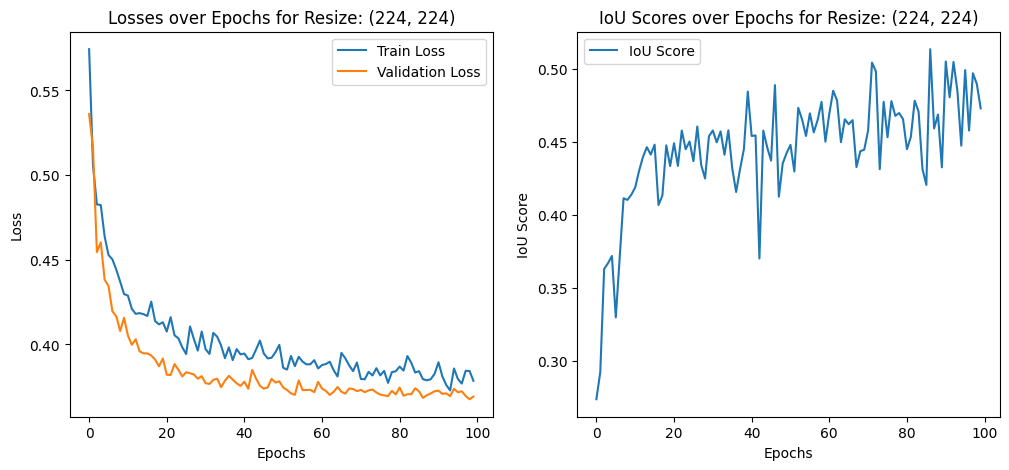

In [9]:
sizes = [(224, 224), ]
num_epochs = 100
# Suponiendo que estás ejecutando esto desde el directorio principal de tu proyecto
base_path = os.getcwd()  # Obtener la ruta del directorio actual donde se ejecuta el script
base_path = os.path.join(base_path, 'MBDS/png')  # Añadir subdirectorio 'images' a la ruta base

best_loss = 0  # Inicialización de la mejor pérdida como cero para comparaciones futuras

torch.cuda.empty_cache()  # Limpiar la caché de CUDA para liberar memoria del GPU

for resize in sizes:
    print(f"Training model with image size: {resize}")  # Informar sobre el tamaño de imagen con el que se va a entrenar
    train_loader, val_loader = create_dataloaders_onehot(base_path, resize[0])  # Crear DataLoader para entrenamiento y validación

    # Reajustar listas de pérdidas e IoU para cada tamaño
    train_losses = []
    val_losses = []
    iou_scores = []

    for epoch in range(num_epochs):  # Bucle sobre cada época
        model.train()  # Poner el modelo en modo entrenamiento
        running_loss = 0.0
        train_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=True)  # Usar tqdm para la barra de progreso
        for images, masks in train_tqdm:
            images, masks = images.to(device), masks.to(device)  # Mover imágenes y máscaras al dispositivo (GPU o CPU)
            
            optimizer.zero_grad()  # Resetear los gradientes del optimizador
            outputs = model(images)  # Obtener las salidas del modelo
            loss = criterion(outputs, masks)  # Calcular la pérdida
            loss.backward()  # Retropropagación de la pérdida
            optimizer.step()  # Actualizar los pesos del modelo
            
            running_loss += loss.item() * images.size(0)  # Acumular la pérdida ajustada por el tamaño del batch
            train_tqdm.set_postfix(loss=(running_loss / (train_tqdm.last_print_n + 1)))  # Mostrar la pérdida promedio en tqdm
        
        epoch_loss = running_loss / len(train_loader.dataset)  # Calcular la pérdida promedio de la época
        train_losses.append(epoch_loss)  # Guardar la pérdida de entrenamiento

        val_loss, average_iou = validate_model(val_loader, model, output_size=1344, device=device, criterion=criterion)  # Validar el modelo
        val_losses.append(val_loss)  # Guardar la pérdida de validación
        iou_scores.append(average_iou)  # Guardar el IoU promedio
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Average IoU: {iou_scores[-1]:.4f}')

        if average_iou > best_loss:  # Guardar el modelo si el IoU promedio es el mejor hasta ahora
            model_save_path = os.path.join('saved_models', f'model_cropped_MBDS{resize[0]}x{resize[1]}.pth')
            os.makedirs('saved_models', exist_ok=True)  # Crear el directorio si no existe
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
            best_loss = average_iou

    # Opcionalmente, graficar los resultados para cada tamaño
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Losses over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label='IoU Score')
    plt.title(f'IoU Scores over Epochs for Resize: {resize}')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.show()

    model.apply(weight_reset)  # Reiniciar los pesos del modelo para evitar el efecto de entrenamiento residual en la próxima iteración

In [10]:
def create_test_dataloader(base_path, batch_size, resize):
    """
    Creates a DataLoader for the test dataset with specific transformations for images and masks.

    Args:
        base_path (str): Base path where image and mask directories are stored.
        batch_size (int): Number of samples per batch.
        resize (int): Size to which images and masks will be resized.

    Returns:
        DataLoader: DataLoader object configured for the test dataset.
    """
    # Transformations for images
    transform_image = transforms.Compose([
        transforms.Resize(1344),  # Resize images to a fixed size
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
    ])
    
    # Transformations for masks, including conversion to one-hot format
    transform_mask = transforms.Compose([
        transforms.Resize(1344),  # Resize masks to the same size as images
        ToOneHot(),  # Convert masks to one-hot format
        # Note: Tensor conversion is handled internally by ToOneHot if necessary
    ])
    
    # Directories where the test images and masks are located
    test_dir = os.path.join(base_path, 'test')
    test_mask_dir = os.path.join(base_path, 'test_labels')
    # Create a dataset using the defined transformations
    test_dataset = SatelliteBuildingDataset(test_dir, test_mask_dir, transform_image, transform_mask)
    # Create the DataLoader with the test data
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_loader

def test_and_plot_model(val_loader, model, output_size, device, num_examples=1):
    """
    Evaluates the model and visualizes the results for a limited set of examples from the validation DataLoader.

    Args:
        val_loader (DataLoader): DataLoader that provides test or validation data.
        model (torch.nn.Module): Neural network model to be evaluated.
        output_size (int): Desired output size for the image segments.
        device (torch.device): Device on which the model is running (CPU or GPU).
        num_examples (int): Number of examples to visualize.
    """
    model.eval()  # Set the model to evaluation mode
    for batch_idx, (images, masks) in enumerate(val_loader):
        if batch_idx >= num_examples:
            break
        images = images.to(device)
        masks = masks.to(device)
        predictions = torch.zeros_like(masks)  # Prepare tensor to store predictions

        for i, (image, mask) in enumerate(zip(images, masks)):
            segments, coords = split_image_into_segments(image.cpu(), output_size)
            full_mask = predict_and_recombine_segments(segments, coords, model, output_size, image.shape, device)
            predictions[i] = full_mask.to(device)
        
            # Convert one-hot masks to a single channel for visualization
            mask_single_channel = torch.argmax(mask, dim=0).cpu()
            full_mask_single_channel = torch.argmax(full_mask, dim=0).cpu()
        
            # Setup plots to show the original image, the original mask, and the predicted mask
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.axis("off")
        
            plt.subplot(1, 3, 2)
            plt.imshow(mask_single_channel, cmap="gray")
            plt.title("Original Mask")
            plt.axis("off")
        
            plt.subplot(1, 3, 3)
            plt.imshow(full_mask_single_channel, cmap="gray")
            plt.title("Predicted Full Mask")
            plt.axis("off")
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


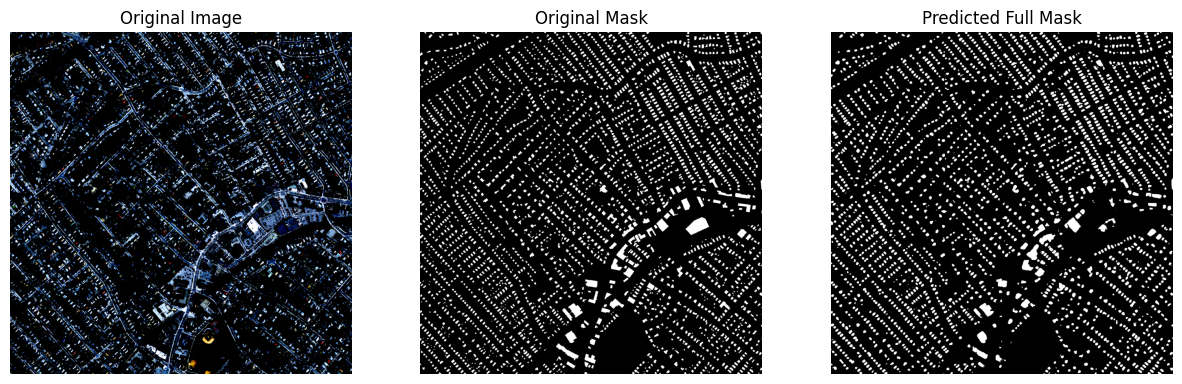

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


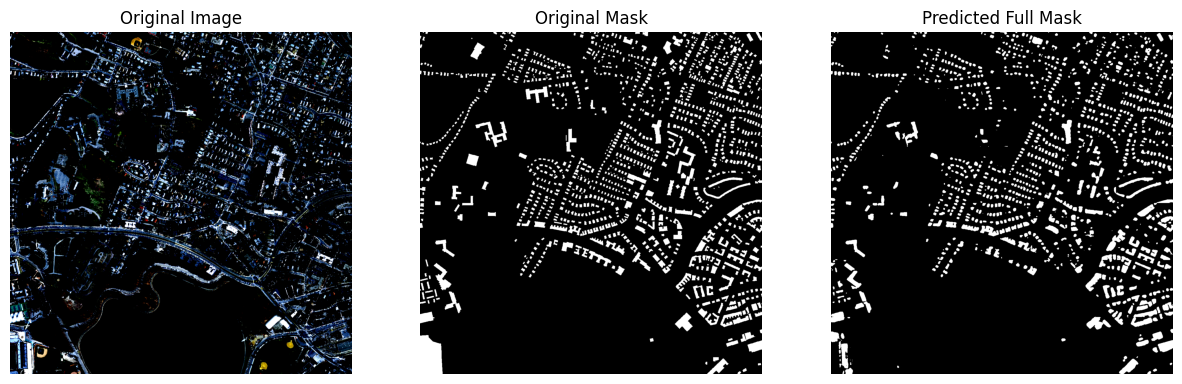

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


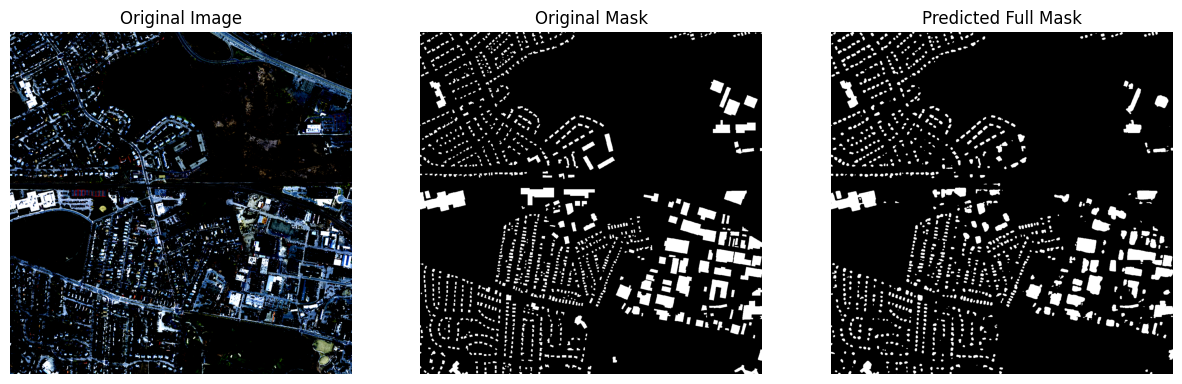

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


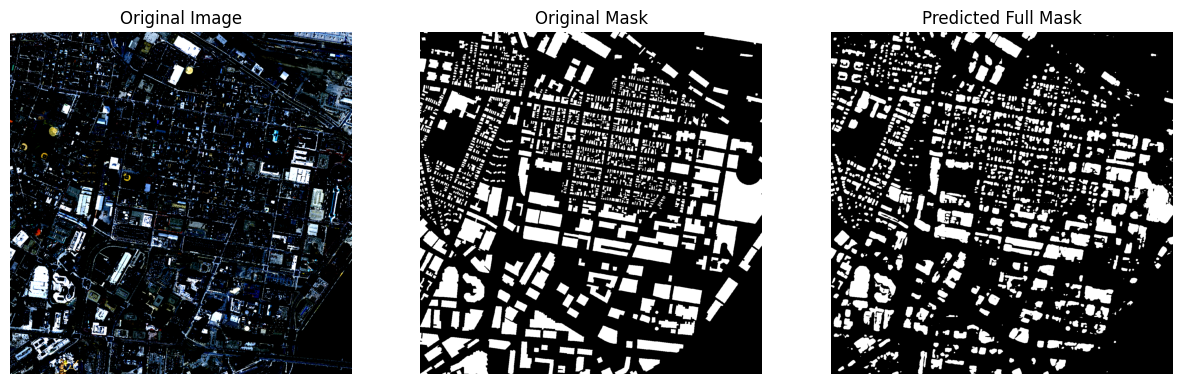

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


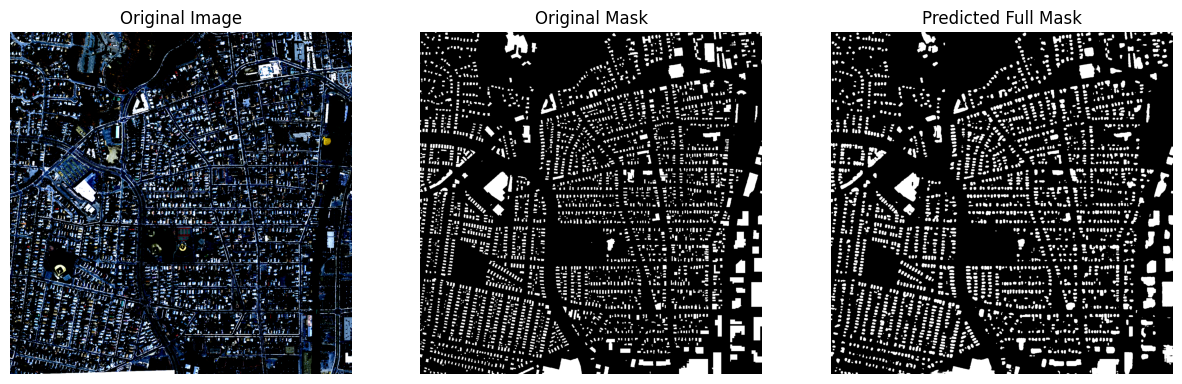

In [11]:
batch_size = 1  # Batch size set to 1, useful for detailed evaluations or where individual processing is required
current_directory = os.getcwd()  # Assuming 'current_directory' is defined somewhere else in the code
base_path = os.path.join(current_directory, 'MBDS/png')

# Loop over different image sizes to test the model with each size configuration
for resize in sizes:
    model_path = f'saved_models/model_cropped_MBDS{resize[0]}x{resize[1]}.pth'  # Path to the saved model
    test_loader = create_test_dataloader(base_path, batch_size, resize)  # Create DataLoader for the test set

    model = UNet()  # Creation of the model instance, assuming it is a U-Net
    model.load_state_dict(torch.load(model_path))  # Load the model weights from the saved file
    model.to(device)  # Move the model to the appropriate device (GPU or CPU)

    # Run the function that tests the model and visualizes the results
    # Note: Ensure that 'output_size' is correctly defined here to match the logic of 'test_and_plot_model'
    test_and_plot_model(test_loader, model, resize[0], device, num_examples=5)